# Wrangling Data From Bay Area Bike Share Published Data - Trips

### Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from wranglingutils import time_marker as tm
from wranglingutils import csv_chunk_importer

In [3]:
from math import ceil

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

COLOR_BLU = '#0074C8'
COLOR_YEL = '#FACD6B'
COLOR_GRY = '#71C9BE'
COLOR_GRE = '#85B74A'

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25
TICK_FONT_SIZE = 10
FIG_SIZE = (15,6)

## Import Data

<p>Trip data, records of all reported trips taken by Bike Share Users</p>

In [5]:
tip_df_columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 
                  'end_date', 'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 
                  'zip_code']

trips_df = csv_chunk_importer(file_path_slug='../00_source_data/bayareabikeshare/*trip_data.csv', 
                                 column_labels=tip_df_columns, 
                                 chunk_size=10000, 
                                 drop_dups=True)

[19:08:33.154640] Started Loading Data...
[19:08:34.258244] Finished file! ( 1 of  4)
[19:08:34.750439] Finished file! ( 2 of  4)
[19:08:35.952351] Finished file! ( 3 of  4)
[19:08:36.530180] Finished file! ( 4 of  4)
[19:08:36.530294] concatenating chunks...
[19:08:38.556645] Data Loaded Successfully!


In [6]:
trips_df['start_date'] = pd.to_datetime(trips_df['start_date'])
trips_df['end_date'] = pd.to_datetime(trips_df['end_date'])

In [7]:
sf_stations = pd.read_pickle('../00_clean_data/bayareabikeshare/sf_station_data_cleaned.pkl')

sf_station_ids = sf_stations.station_id.unique()

## Zip Codes
<ul>
    <li><b>us_zipcodes:</b> list of all US zipcodes, used to validate user input</li>
    <li><b>bayzips:</b> a list of all bay are zipcodes, use to determine a `local` customer</li>
</ul>

In [8]:
us_zipcodes = csv_chunk_importer(file_path_slug='../00_source_data/us_postal_codes.csv', 
                                 chunk_size=10000, 
                                 drop_dups=True)

us_zipcodes.columns = [x.replace(' ', '_').lower() for x in us_zipcodes.columns]

# left pad zip_code with zeros
us_zipcodes['zip_code'] = us_zipcodes['zip_code'].apply(lambda x: '{0:05d}'.format(x))

us_zips = [str(x) for x in us_zipcodes.zip_code.unique()]

us_zipcodes.head(3)

[19:17:23.042959] Started Loading Data...
[19:17:23.150325] Finished file! ( 1 of  1)
[19:17:23.150441] concatenating chunks...
[19:17:23.202809] Data Loaded Successfully!


,zip_code,place_name,state,state_abbreviation,county,latitude,longitude
0,00501,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
1,00544,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
2,01001,Agawam,Massachusetts,MA,Hampden,42.0702,-72.6227


In [9]:
bay_area_zipcodes = csv_chunk_importer(file_path_slug='../00_source_data/bayarea_zipcodes.csv', 
                                 chunk_size=10000, 
                                 drop_dups=True)
bayzips = bay_area_zipcodes.ZIP.unique()

bayzips = [str(z) for z in bayzips]

[19:17:23.297936] Started Loading Data...
[19:17:23.318316] Finished file! ( 1 of  1)
[19:17:23.318472] concatenating chunks...
[19:17:23.329229] Data Loaded Successfully!


In [10]:
bay_zips = us_zipcodes[((us_zipcodes.state_abbreviation == 'CA') & (us_zipcodes.place_name == 'San Jose')) 
            | (us_zipcodes.zip_code.isin(bayzips))].zip_code.unique()

## check if zipcode is a valid US Zipcode

In [11]:
trips_df['zip_code'] = trips_df['zip_code'].apply(lambda x: '0' if x == 'nil' else str(x).split('-')[0].split('.')[0][:5])

In [12]:
# tag trips if they have a valid USA Zipcode
tm("tagging valid USA Zipcodes")
trips_df['us_zip']   = False
us_idx = trips_df[trips_df.zip_code.isin(us_zips)].index
trips_df.iloc[us_idx,list(trips_df.columns).index('us_zip')] = True

# replace non valid USA Zip Codes with '00000'
tm("replacing non valid zip codes with '00000'")
non_us_idx = trips_df[~trips_df.zip_code.isin(us_zips)].index
trips_df.iloc[non_us_idx,list(trips_df.columns).index('zip_code')] = '00000'

# tag trips that are in local bay area zip codes
tm("tagging local  Bay Area Zip Codes")
trips_df['is_local']   = False
local_idx = trips_df[trips_df.zip_code.isin(bayzips)].index
trips_df.iloc[local_idx,list(trips_df.columns).index('is_local')] = True

[19:17:24.627554] tagging valid USA Zipcodes
[19:17:24.979237] replacing non valid zip codes with '00000'
[19:17:25.160677] tagging local  Bay Area Zip Codes


## Append User Home City, state, and county

In [13]:
tm('merge user home state and city')
trips_df = trips_df.merge(us_zipcodes.iloc[:,[0, 1, 3, 4]], on = 'zip_code', how='left')
trips_df.rename(columns={'place_name' : 'user_home_city',
                    'state_abbreviation' : 'user_home_state',
                    'county' : 'user_home_county'}, inplace=True)

[19:17:25.390445] merge user home state and city


## Plot Counts
<p>Grup data frames by a specific column, option to highlight a specific set of columns</p>

In [14]:
from wranglingutils import plot_counts

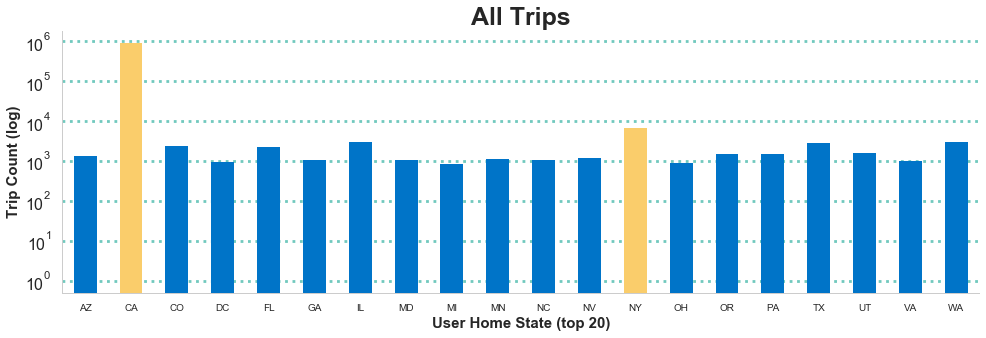

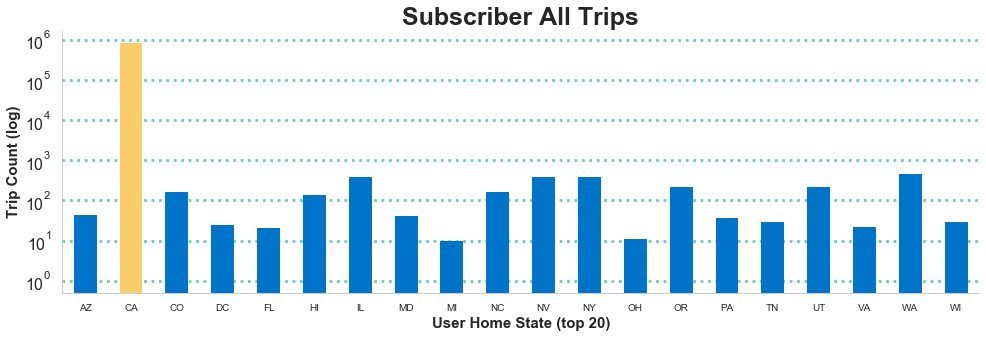

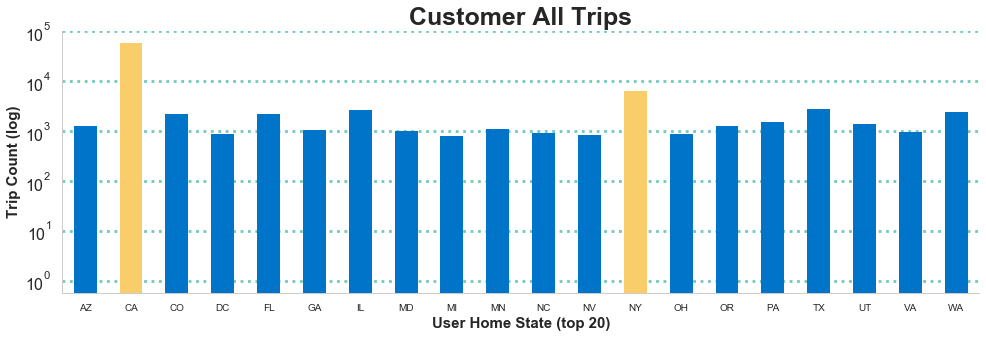

In [16]:
df = trips_df.groupby('user_home_state').count()['trip_id'].copy()
highlight_labels = df[df >= df.quantile(0.975)].index
plot_counts(df, highlight_labels=highlight_labels,
                x_label='User Home State',
                y_label='Trip Count',
                title='All Trips')

df = trips_df[trips_df.subscriber_type == 'Subscriber'].groupby('user_home_state').count()['trip_id'].copy()
highlight_labels = df[df >= df.quantile(0.975)].index
plot_counts(df, highlight_labels=highlight_labels,
                x_label='User Home State',
                y_label='Trip Count',
                title='Subscriber All Trips')

df = trips_df[trips_df.subscriber_type != 'Subscriber'].groupby('user_home_state').count()['trip_id'].copy()
highlight_labels = df[df >= df.quantile(0.975)].index
plot_counts(df, highlight_labels=highlight_labels,
                x_label='User Home State',
                y_label='Trip Count',
                title='Customer All Trips')

## Plot Trip Counts by Home City, Separated by State

In [17]:
n = 10
top_n_states = trips_df.groupby('user_home_state').count()['trip_id'].sort_values(ascending=False)[:n].index
top_n_states

Index(['CA', 'NY', 'IL', 'WA', 'TX', 'CO', 'FL', 'UT', 'PA', 'OR'], dtype='object', name='user_home_state')

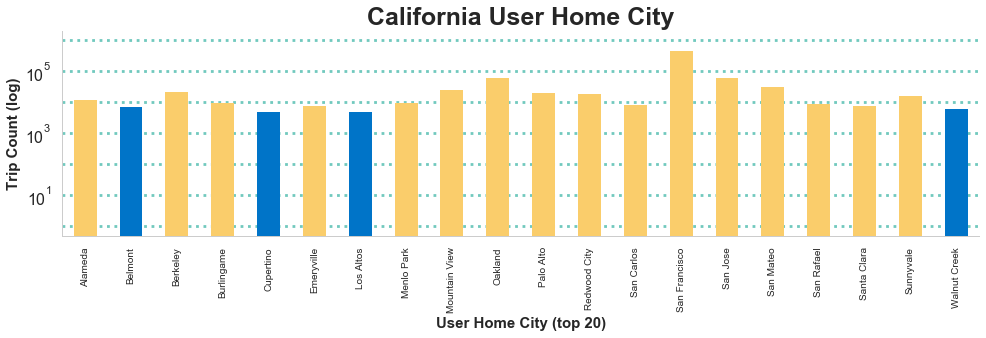

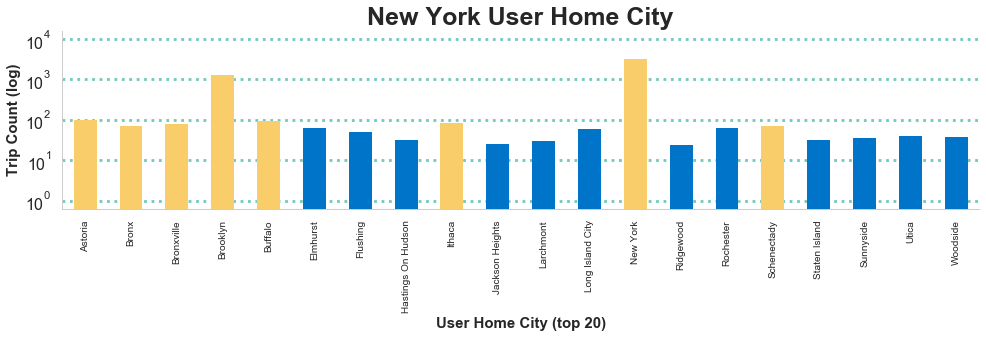

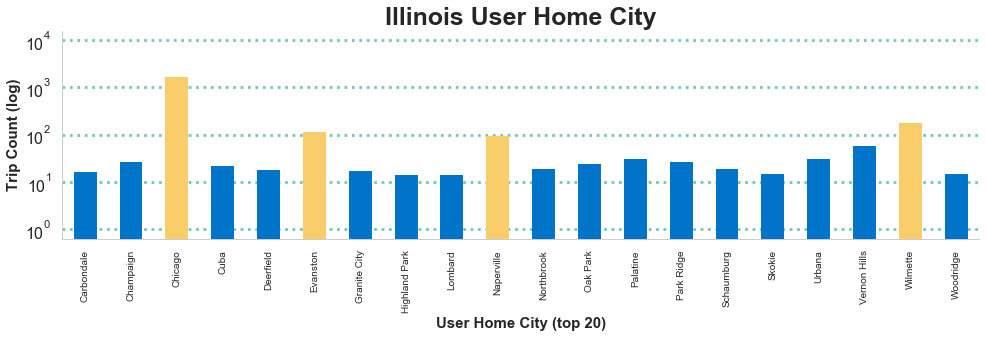

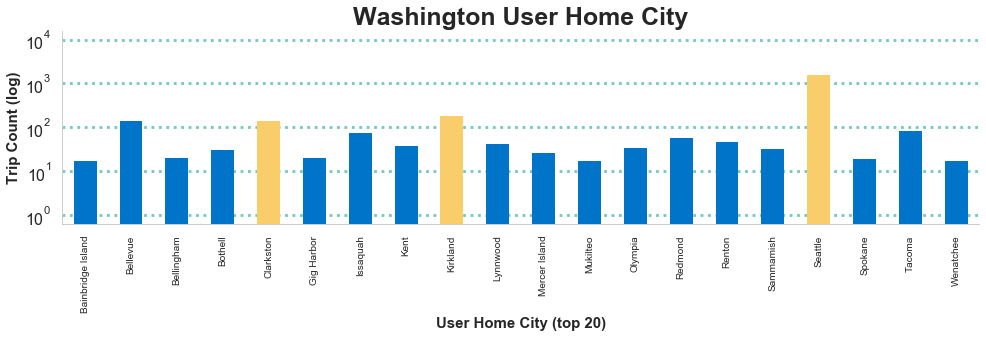

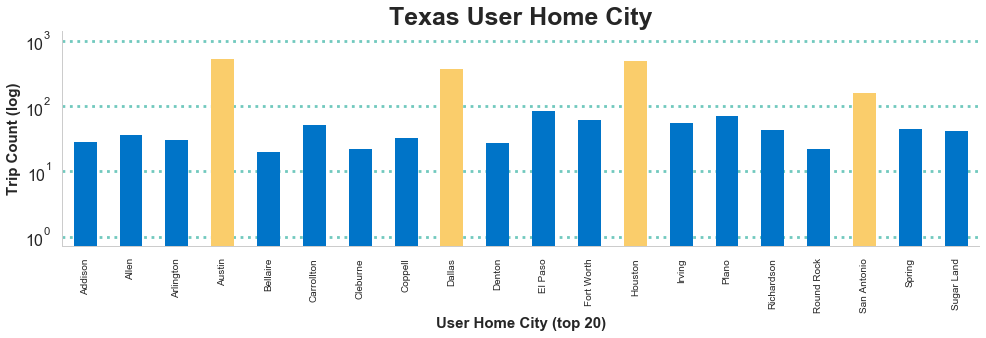

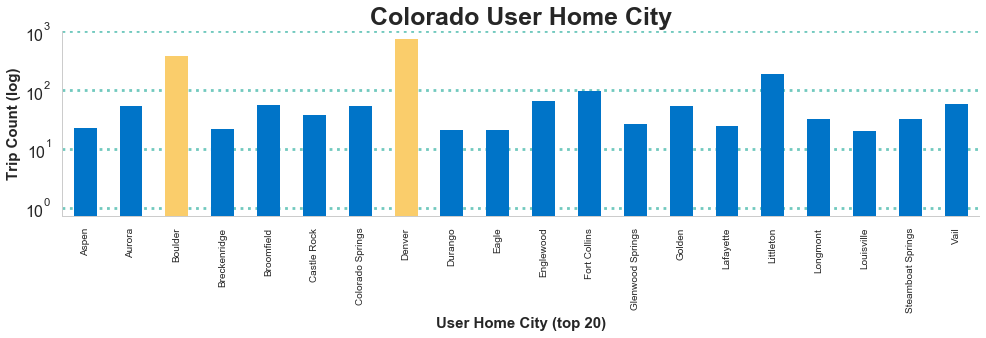

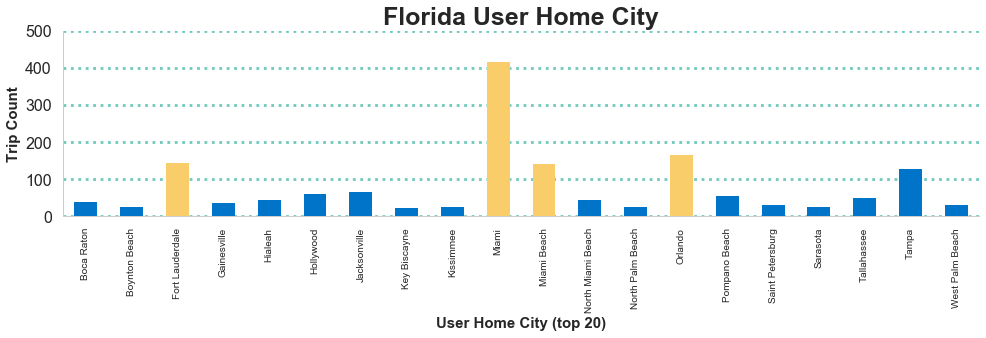

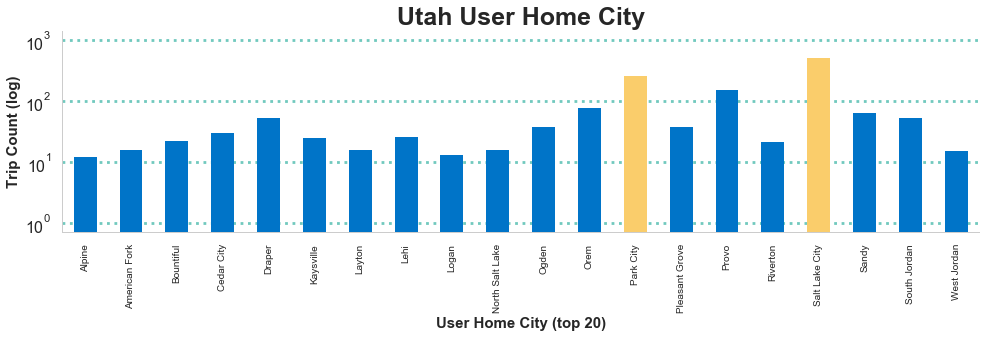

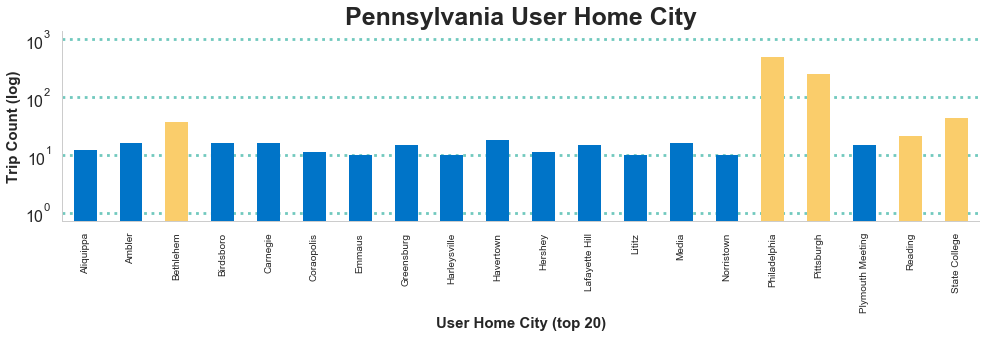

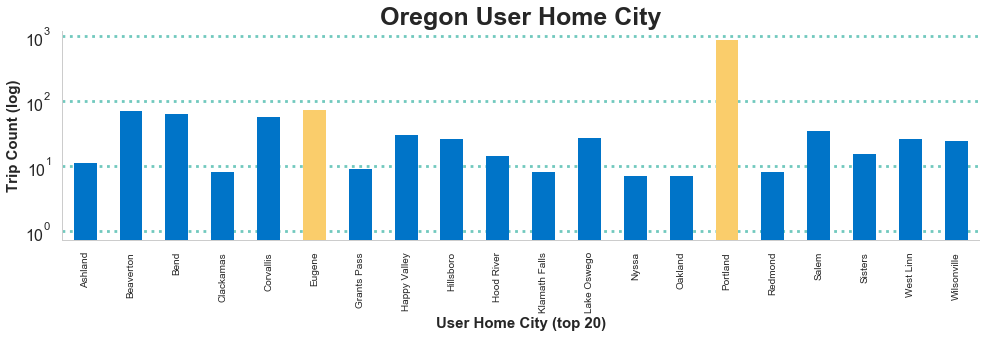

In [18]:
for state in top_n_states:
    full_name = us_zipcodes[us_zipcodes.state_abbreviation == state].state.unique()[0]
    if str(full_name) != 'nan':
#         print('{:<3}{:}'.format(state, full_name))
        df = trips_df[trips_df.user_home_state == state].groupby('user_home_city').count()['trip_id']

        highlight_labels = df[df >= df.quantile(0.975)].index
        plot_counts(df, highlight_labels=highlight_labels,
                        x_label='User Home City',
                        x_label_rot = 90,
                        y_label='Trip Count',
                        y_interval=100,
                        title='{} User Home City'.format(full_name.title()), 
                        figsize=FIG_SIZE)

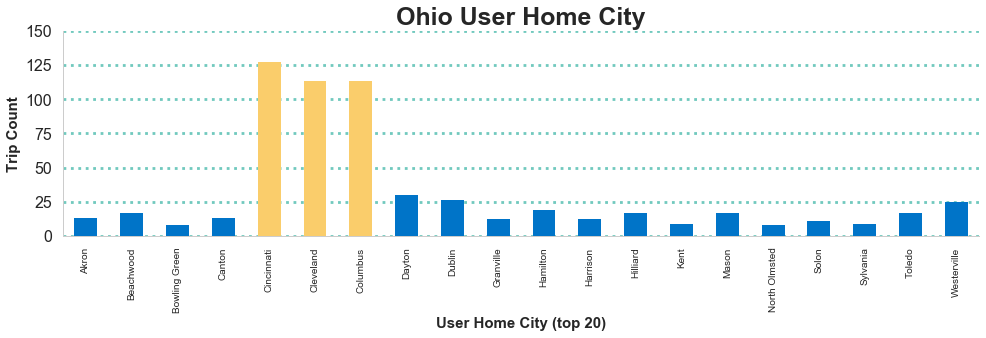

In [19]:
df = trips_df[trips_df.user_home_state == 'OH'].groupby('user_home_city').count()['trip_id']

highlight_labels = df[df >= df.quantile(0.975)].index
plot_counts(df, highlight_labels=highlight_labels,
                x_label='User Home City',
                x_label_rot = 90,
                y_label='Trip Count',
                title='Ohio User Home City', 
                figsize=FIG_SIZE)

In [20]:
trips_df[(trips_df.user_home_state == 'OH') & (trips_df.user_home_city == 'Lewis Center')]

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,subscriber_type,zip_code,us_zip,is_local,user_home_city,user_home_state,user_home_county
518128,834519,469,2015-07-06 12:37:00,Golden Gate at Polk,59,2015-07-06 12:45:00,Market at 4th,76,475,Customer,43035,True,False,Lewis Center,OH,Delaware
518129,834518,478,2015-07-06 12:37:00,Golden Gate at Polk,59,2015-07-06 12:45:00,Market at 4th,76,504,Customer,43035,True,False,Lewis Center,OH,Delaware
518811,833685,244,2015-07-05 15:18:00,Market at 10th,67,2015-07-05 15:23:00,Civic Center BART (7th at Market),72,426,Customer,43035,True,False,Lewis Center,OH,Delaware
518812,833684,251,2015-07-05 15:18:00,Market at 10th,67,2015-07-05 15:22:00,Civic Center BART (7th at Market),72,483,Customer,43035,True,False,Lewis Center,OH,Delaware
518831,833661,2235,2015-07-05 14:38:00,Market at 10th,67,2015-07-05 15:15:00,Market at 10th,67,310,Customer,43035,True,False,Lewis Center,OH,Delaware
518832,833660,2222,2015-07-05 14:38:00,Market at 10th,67,2015-07-05 15:15:00,Market at 10th,67,354,Customer,43035,True,False,Lewis Center,OH,Delaware


## Cleaning Support Functions
<p>General Cleaning functions</p>

In [21]:
def clean_trip_frame(df):
    '''Basic Cleanup of column types and appends a 'duration_minutes' 
        column converted from given 'duration' which is in seconds'''
    # set column types
    tm('Setting data types...')
    df['start_date']       = pd.to_datetime(df['start_date'], format="%m/%d/%Y %H:%M")
    df['end_date']         = pd.to_datetime(df['end_date'],   format="%m/%d/%Y %H:%M")
    df['trip_id']          = df['trip_id'].astype('int')
    df['duration']         = df['duration'].astype('int')    
    df['start_terminal']   = df['start_terminal'].astype('int')
    df['end_terminal']     = df['end_terminal'].astype('int')
    df['bike_id']          = df['bike_id'].astype('int')
    df['subscriber_type']  = df['subscriber_type'].astype('category')
    
    # add 'duration_minutes' column
    tm('add duration_minutes column')
    df['duration_minutes'] = df.duration.apply(lambda x: x/60.)
    df['duration_minutes'] = df['duration_minutes'].astype('float')
    
    # add 'billed_minutes' and 'billed_periods' columns
    # customers are billed by the minute, round up to nearest minute duration
    # a billed period is 5 minutes long
    df['billed_minutes'] = df.duration.apply(lambda x: ceil(x/60.))
    df['billed_minutes'] = df['billed_minutes'].astype('int')
    df['billed_periods'] = df.billed_minutes.apply(lambda x: int(ceil(x/5)))
    
#     # Clean Zipcode
#     tm('cleaning zipcodes')
#     df['zip_code'] = df.zip_code.apply(clean_zipcode)
    
    # rename columns for clarity
    df.rename(columns={'zip_code': 'user_zip', 'subscriber_type': 'user_type'}, inplace=True)

    df.reset_index(inplace=True, drop=True)
    
    tm('done!')
    return df

# Cleaning Data
<ul>
    <li>Format zip codes to take only first 5 digits, this data is self reported and often wrongly input per Bay Area Bike Share Notes</li>
    <li>For other data it is mostly just setting a propper data type</li>
    <li>
        <ul>Duration is convered to billable time windows as:
            <li>`billed_minutes` rounds up rental duration minutes to next full minute</li>
            <li>`billed_periods` is the number of 5 minute intervals in `billed_minutes`, rounded up to the next full period</li>
        <ul>
    </li>
</ul>

In [22]:
# clean data frames
tm('Trip Data Cleanup Started')
trips_df = clean_trip_frame(trips_df)
tm('Cleanup Complete!')

[19:17:43.215998] Trip Data Cleanup Started
[19:17:43.216807] Setting data types...
[19:17:43.474594] add duration_minutes column
[19:17:45.783836] done!
[19:17:45.784059] Cleanup Complete!


In [23]:
trips_df.head(3).transpose()

,0,1,2
trip_id,913465,913466,913467
duration,746,969,233
start_date,2015-09-01 00:10:00,2015-09-01 00:15:00,2015-09-01 00:15:00
start_station_name,San Francisco Caltrain 2 (330 Townsend),Clay at Battery,Davis at Jackson
start_terminal,69,41,42
end_date,2015-09-01 00:23:00,2015-09-01 00:31:00,2015-09-01 00:19:00
end_station_name,San Francisco City Hall,Washington at Kearny,Commercial at Montgomery
end_terminal,58,46,45
bike_id,238,16,534
user_type,Subscriber,Subscriber,Subscriber


In [24]:
trips_df.describe()

,trip_id,duration,start_terminal,end_terminal,bike_id,duration_minutes,billed_minutes,billed_periods
count,9.836480e+05,9.836480e+05,983648.000000,983648.000000,983648.000000,983648.000000,983648.000000,983648.000000
mean,6.721238e+05,1.018932e+03,58.121022,58.100089,423.319779,16.982206,17.473353,3.884966
std,3.851056e+05,1.841684e+04,16.841133,16.912386,158.071344,306.947284,306.946965,61.390235
min,4.069000e+03,6.000000e+01,2.000000,2.000000,9.000000,1.000000,1.000000,1.000000
25%,3.359168e+05,3.470000e+02,50.000000,50.000000,328.000000,5.783333,6.000000,2.000000
50%,6.779755e+05,5.180000e+02,62.000000,62.000000,437.000000,8.633333,9.000000,2.000000
75%,1.001672e+06,7.480000e+02,70.000000,70.000000,544.000000,12.466667,13.000000,3.000000
max,1.338408e+06,1.727040e+07,91.000000,91.000000,878.000000,287840.000000,287840.000000,57568.000000


# Correct Relocated Stations

<p> There was a delay in station_id updates when stations 23, 24, 25, and 26 were relocated, update status information by changing the station_id for these stations in dates after they were relocated </p>

In [25]:
def date_fixes(df, old_terminal, new_terminal, change_date):
    '''Correct dates on terminal relocations'''
        
    # Fix A to B - Start Terminal
    tm('Setting {} to {} occuring before {}'.format(old_terminal, new_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == old_terminal) & (df.start_date >= change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_start)))
    df.loc[index_to_update_start, 'start_terminal'] = new_terminal

    # Fix A to B - End Terminal
    index_to_update_end   = df[(df.end_terminal == old_terminal) & (df.end_date >= change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_end)))
    df.loc[index_to_update_end, 'end_terminal'] = new_terminal
    
    # Fix B to A - Start Terminal
    tm('Setting {} to {} occuring after  {}'.format(new_terminal, old_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == new_terminal) & (df.start_date < change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_start)))
    df.loc[index_to_update_start, 'start_terminal'] = old_terminal

    # Fix B to A - End Terminal
    index_to_update_end   = df[(df.end_terminal == new_terminal) & (df.end_date < change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_end)))
    df.loc[index_to_update_end, 'end_terminal'] = old_terminal
    
    return df

#### On July 5, 2016 station 23 was relocated to station 88, and station 24 was relocated to station 89

In [26]:
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 23, 88, change_date)
trips_df = date_fixes(trips_df, 24, 89, change_date)

[19:17:46.856632] Setting 23 to 88 occuring before 2016-07-05 00:00:00
	Updating 0 records...
	Updating 0 records...
[19:17:47.006173] Setting 88 to 23 occuring after  2016-07-05 00:00:00
	Updating 9 records...
	Updating 18 records...
[19:17:47.088366] Setting 24 to 89 occuring before 2016-07-05 00:00:00
	Updating 0 records...
	Updating 0 records...
[19:17:47.170303] Setting 89 to 24 occuring after  2016-07-05 00:00:00
	Updating 11 records...
	Updating 9 records...


#### On August 4, 2016 station 25 was relocated to station 91, and station 26 was relocated to station 90

In [27]:
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 25, 91, change_date)
trips_df = date_fixes(trips_df, 26, 90, change_date)

[19:17:47.260649] Setting 25 to 91 occuring before 2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...
[19:17:47.350478] Setting 91 to 25 occuring after  2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...
[19:17:47.430434] Setting 26 to 90 occuring before 2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...
[19:17:47.510565] Setting 90 to 26 occuring after  2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...


## Prune Trips not within San Francisco
<p>We are only concerned with trips that both start and end at San Francisco Stations in this analysis, remove all others</p>

In [28]:
tm('Subset to only include trips that are within San Francisco')
trips_df = trips_df[(trips_df.start_terminal.isin(sf_station_ids)) & (trips_df.end_terminal.isin(sf_station_ids))].copy()
tm('done')

[19:17:47.606692] Subset to only include trips that are within San Francisco
[19:17:47.911112] done


## Prune Trips to only those less than 3 hours long
<p>The duration in minutes of each trip has a very large spread, with the longest trip (an extreme outlier) taking nearly 200 days to complete a trip!  The Bay Area Bike Share bills in Customer and Subscriber Tiers that allow for different pricing, but the global truth is that no rider can use a bike as part of the program for more than 3 hour without incurring a heafty set of fees.</p>
<p>In fact, the idealized window set out by the program is for just 30 minutes, with a minute by minute charge being tacked onto rentals for each minute the bike is not returned after that.</p>

<ul>
    <li>There are 983648 total recorded trips</li>
    <li>There are 936280 trips 30 minutes or less, this is 95.184 of all recorded trips</li>
    <li>There are 973074 trips 3 hours or less, this is 98.925 of all recorded trips</li>
</ul>

In [29]:
count_30min_trips = trips_df[trips_df.duration_minutes < 30].shape[0]
count_3hr_trips = trips_df[trips_df.duration_minutes < 180].shape[0]

print('There are {:d} total recorded trips'.format(trips_df.shape[0]))
print('There are {:d} trips 30 minutes or less, this is {:2.3f} of all recorded trips'.format(count_30min_trips, 100.*count_30min_trips/trips_df.shape[0]))
print('There are {:d} trips 3 hours or less, this is {:2.3f} of all recorded trips'.format(count_3hr_trips, 100.*count_3hr_trips/trips_df.shape[0]))

There are 891200 total recorded trips
There are 851921 trips 30 minutes or less, this is 95.593 of all recorded trips
There are 882240 trips 3 hours or less, this is 98.995 of all recorded trips


In [30]:
def plot_billed_min_distribution(df, max_minutes=180, file_suffix='3hr'):
    df_subset = df[df.billed_minutes <= max_minutes].copy()

    plt.subplots(figsize=FIG_SIZE)
    ax = sns.countplot(x="billed_minutes", data=df_subset, color=COLOR_BLU)

    plt.xlabel('Trip Duration (Billed Minutes)', size=LABEL_FONT_SIZE)
    plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE)
    plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE)

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    x_ticks = [x for x in range(0, max_minutes+5, 5)]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], size=TICK_FONT_SIZE)
    for x in x_ticks:
        ax.axvline(x, linestyle=':', color=COLOR_GRY, zorder=-1)


    y_ticks = [y for y in range(0, 100000, 10000)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(['{:d}K'.format(int(y/1000)) for y in y_ticks], size=TICK_FONT_SIZE)

    plt.grid(False)
    plt.tight_layout()
    plt.savefig('../charts/trip_duration_distribution_{}.png'.format(file_suffix))
    plt.show()
    plt.close()

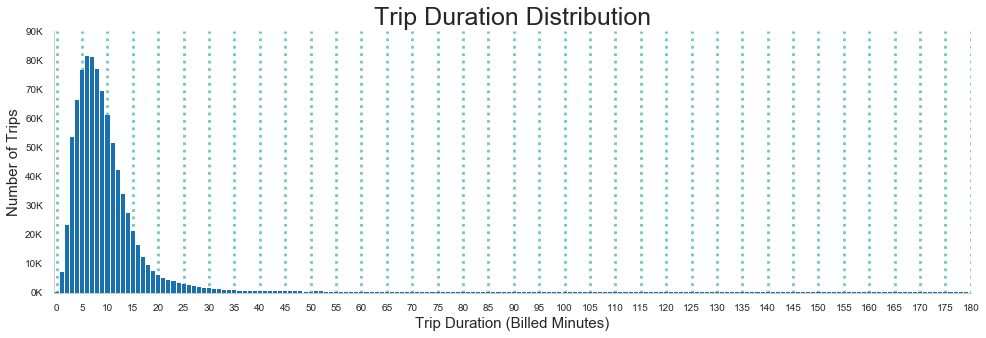

In [31]:
plot_billed_min_distribution(trips_df, max_minutes=180, file_suffix='3hr')

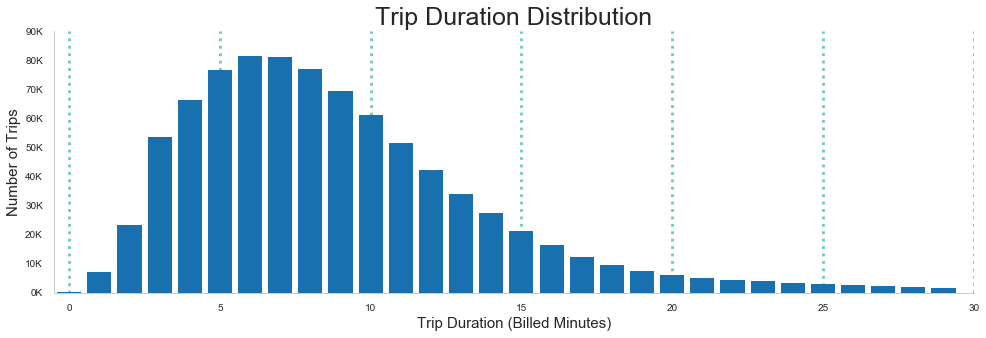

In [32]:
plot_billed_min_distribution(trips_df, max_minutes=30, file_suffix='30min')

In [33]:
# prune data to exclude trips longer than 3 hours
tm('Removing trips longer than 3 hours')

cutoff_minutes = 180

trips_df = trips_df[trips_df.billed_minutes < cutoff_minutes].copy()
trips_df.reset_index(inplace=True, drop=True)

print(trips_df.shape)
tm('done!')

[19:17:50.969229] Removing trips longer than 3 hours
(882190, 19)
[19:17:51.346909] done!


## Clean Up Column Labels

In [34]:
try:
    trips_df.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 
                        'start_station_id', 'end_date', 'end_station_name', 'end_station_id', 
                        'bike_id', 'user_type', 'user_zip', 'is_us_zip', 'is_local',
                       'user_home_city', 'user_home_state', 'user_home_county',
                       'duration_minutes', 'billed_minutes', 'billed_periods']

except:
    pass
trips_df.drop(['is_us_zip'], axis=1, inplace=True)

trips_df.head()

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,user_type,user_zip,is_local,user_home_city,user_home_state,user_home_county,duration_minutes,billed_minutes,billed_periods
0,913465,746,2015-09-01 00:10:00,San Francisco Caltrain 2 (330 Townsend),69,2015-09-01 00:23:00,San Francisco City Hall,58,238,Subscriber,94107,True,San Francisco,CA,City and County of San Francisco,12.433333,13,3
1,913466,969,2015-09-01 00:15:00,Clay at Battery,41,2015-09-01 00:31:00,Washington at Kearny,46,16,Subscriber,94133,True,San Francisco,CA,City and County of San Francisco,16.150000,17,4
2,913467,233,2015-09-01 00:15:00,Davis at Jackson,42,2015-09-01 00:19:00,Commercial at Montgomery,45,534,Subscriber,94111,True,San Francisco,CA,City and County of San Francisco,3.883333,4,1
3,913468,213,2015-09-01 01:29:00,Clay at Battery,41,2015-09-01 01:32:00,Steuart at Market,74,312,Subscriber,94107,True,San Francisco,CA,City and County of San Francisco,3.550000,4,1
4,913469,574,2015-09-01 01:33:00,Steuart at Market,74,2015-09-01 01:42:00,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107,True,San Francisco,CA,City and County of San Francisco,9.566667,10,2


# Calculate Additional Charges

<ul>
    <li><b>Subscribers:</b> get first 45 mintues free, then \$3.00 per additional 15 minute rental window</li>
    <li><b>Customers:</b> get first 30 minutes free, then \$3.00 per additional 15 minute rental window</li>
</ul>

In [35]:
def trip_additional_charges(user_type, billed_minutes):
    
    if billed_minutes < 30:
        return 0.0
    
    elif user_type.title() == 'Subscriber':
        return ceil((billed_minutes - 45) / 15)*3
        
    elif user_type.title() == 'Customer':
        return ceil((billed_minutes - 30) / 15)*3    
    
    else:
        return 0.0

In [36]:
trips_df['additional_charges'] = trips_df.apply(lambda row: trip_additional_charges(row['user_type'], row['billed_minutes']), axis=1)

In [37]:
trips_df.head(3).transpose()

,0,1,2
trip_id,913465,913466,913467
duration,746,969,233
start_date,2015-09-01 00:10:00,2015-09-01 00:15:00,2015-09-01 00:15:00
start_station_name,San Francisco Caltrain 2 (330 Townsend),Clay at Battery,Davis at Jackson
start_station_id,69,41,42
end_date,2015-09-01 00:23:00,2015-09-01 00:31:00,2015-09-01 00:19:00
end_station_name,San Francisco City Hall,Washington at Kearny,Commercial at Montgomery
end_station_id,58,46,45
bike_id,238,16,534
user_type,Subscriber,Subscriber,Subscriber


# Write Data to File

In [38]:
trips_df.to_pickle('../00_clean_data/bayareabikeshare/trips_cleaned.pkl')

In [39]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882190 entries, 0 to 882189
Data columns (total 19 columns):
trip_id               882190 non-null int64
duration              882190 non-null int64
start_date            882190 non-null datetime64[ns]
start_station_name    882190 non-null object
start_station_id      882190 non-null int64
end_date              882190 non-null datetime64[ns]
end_station_name      882190 non-null object
end_station_id        882190 non-null int64
bike_id               882190 non-null int64
user_type             882190 non-null category
user_zip              882190 non-null object
is_local              882190 non-null bool
user_home_city        847505 non-null object
user_home_state       847505 non-null object
user_home_county      847505 non-null object
duration_minutes      882190 non-null float64
billed_minutes        882190 non-null int64
billed_periods        882190 non-null int64
additional_charges    882190 non-null float64
dtypes: bool(1), catego

In [40]:
trips_df.head(3).transpose()

,0,1,2
trip_id,913465,913466,913467
duration,746,969,233
start_date,2015-09-01 00:10:00,2015-09-01 00:15:00,2015-09-01 00:15:00
start_station_name,San Francisco Caltrain 2 (330 Townsend),Clay at Battery,Davis at Jackson
start_station_id,69,41,42
end_date,2015-09-01 00:23:00,2015-09-01 00:31:00,2015-09-01 00:19:00
end_station_name,San Francisco City Hall,Washington at Kearny,Commercial at Montgomery
end_station_id,58,46,45
bike_id,238,16,534
user_type,Subscriber,Subscriber,Subscriber


In [41]:
trips_df[(trips_df.user_home_state == 'OH') & (trips_df.user_home_city == 'Lewis Center')]

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,user_type,user_zip,is_local,user_home_city,user_home_state,user_home_county,duration_minutes,billed_minutes,billed_periods,additional_charges
467191,834519,469,2015-07-06 12:37:00,Golden Gate at Polk,59,2015-07-06 12:45:00,Market at 4th,76,475,Customer,43035,False,Lewis Center,OH,Delaware,7.816667,8,2,0.0
467192,834518,478,2015-07-06 12:37:00,Golden Gate at Polk,59,2015-07-06 12:45:00,Market at 4th,76,504,Customer,43035,False,Lewis Center,OH,Delaware,7.966667,8,2,0.0
467794,833685,244,2015-07-05 15:18:00,Market at 10th,67,2015-07-05 15:23:00,Civic Center BART (7th at Market),72,426,Customer,43035,False,Lewis Center,OH,Delaware,4.066667,5,1,0.0
467795,833684,251,2015-07-05 15:18:00,Market at 10th,67,2015-07-05 15:22:00,Civic Center BART (7th at Market),72,483,Customer,43035,False,Lewis Center,OH,Delaware,4.183333,5,1,0.0
467809,833661,2235,2015-07-05 14:38:00,Market at 10th,67,2015-07-05 15:15:00,Market at 10th,67,310,Customer,43035,False,Lewis Center,OH,Delaware,37.250000,38,8,3.0
467810,833660,2222,2015-07-05 14:38:00,Market at 10th,67,2015-07-05 15:15:00,Market at 10th,67,354,Customer,43035,False,Lewis Center,OH,Delaware,37.033333,38,8,3.0
